In [1]:
# importing necessary libraries
import os
import time
import copy
import numpy as np
import pandas as pd
from PIL import Image
import torch,torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
import torch.optim as optim

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from torch.nn import Parameter

In [2]:
from collections.abc import Iterable

def set_freeze_by_idxs(model, idxs, freeze=True): 
    """ Function to freeze layers of model during fine-training"""
    if not isinstance(idxs, Iterable):
        idxs = [idxs]
    num_child = len(list(model.children()))
    idxs = tuple(map(lambda idx: num_child + idx if idx < 0 else idx, idxs))
    for idx, child in enumerate(model.children()):
        if idx not in idxs:
            continue
        for param in child.parameters():
            param.requires_grad = not freeze
    return model
            
def freeze_by_idxs(model, idxs):
    return set_freeze_by_idxs(model, idxs, True)

def unfreeze_by_idxs(model, idxs):
    return set_freeze_by_idxs(model, idxs, False)

def set_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad=False
    return model

def initialize_model(model_name, num_classes, use_pretrained, unfreeze_num):
    """Function to intialize various model ['vgg16','vgg19','resnet101','resnet152','densenet161','densenet201']
        and modify output classifier layers according to number of classes, with "unfreeze_num" of layers freezed.
    """
    if model_name=='vgg16':
        model_pre=models.vgg16(pretrained=use_pretrained) 
        model_pre.features[0].in_channels=1
        model_pre.features[0].weight=Parameter(model_pre.features[0].weight[:,1:2,:,:])
        model_pre=set_parameter_requires_grad(model_pre) 
        num_ftrs=model_pre.classifier[6].in_features # feature_map 
        model_pre.classifier[6]=nn.Linear(num_ftrs,num_classes) 
        if unfreeze_num==1:
            unfreeze=[-1]
        elif unfreeze_num==2:
            unfreeze=[-1,-3]
        elif unfreeze_num==3:
            unfreeze=[-1,-3,-5]
        else:
            unfreeze=[-1,-3,-5,-7]
        model_pre.features=unfreeze_by_idxs(model_pre.features,unfreeze)
        for param in model_pre.classifier.parameters():
            param.requires_grad=True
        input_size=224
    elif model_name=='vgg19':
        model_pre=models.vgg19(pretrained=use_pretrained) 
        model_pre.features[0].in_channels=1
        model_pre.features[0].weight=Parameter(model_pre.features[0].weight[:,1:2,:,:])
        model_pre=set_parameter_requires_grad(model_pre) 
        num_ftrs=model_pre.classifier[6].in_features
        model_pre.classifier[6]=nn.Linear(num_ftrs,num_classes) 
        if unfreeze_num==1:
            unfreeze=[-1]
        elif unfreeze_num==2:
            unfreeze=[-1,-3]
        elif unfreeze_num==3:
            unfreeze=[-1,-3,-5]
        else:
            unfreeze=[-1,-3,-5,-7]
        model_pre.features=unfreeze_by_idxs(model_pre.features,unfreeze)
        for param in model_pre.classifier.parameters():
            param.requires_grad=True
        input_size=224
    elif model_name=='resnet101':
        model_pre=models.resnet101(pretrained=use_pretrained) 
        model_pre.conv1.in_channels=1
        model_pre.conv1.weight=Parameter(model_pre.conv1.weight[:,1:2,:,:])
        model_pre=set_parameter_requires_grad(model_pre)
        num_ftrs=model_pre.fc.in_features 
        model_pre.fc=nn.Linear(num_ftrs,num_classes)
        
        for i in range(unfreeze_num):
            model_pre.layer4=unfreeze_by_idxs(model_pre.layer4,-i)
        for param in model_pre.fc.parameters():
            param.requires_grad=True
        input_size=224
    elif model_name=='resnet152':
        model_pre=models.resnet152(pretrained=use_pretrained) 
        model_pre.conv1.in_channels=1
        model_pre.conv1.weight=Parameter(model_pre.conv1.weight[:,1:2,:,:])
        model_pre=set_parameter_requires_grad(model_pre)
        num_ftrs=model_pre.fc.in_features
        model_pre.fc=nn.Linear(num_ftrs,num_classes)

        for i in range(unfreeze_num):
            model_pre.layer4=unfreeze_by_idxs(model_pre.layer4,-i)
        for param in model_pre.fc.parameters():
            param.requires_grad=True
        input_size=224
    elif model_name=='densenet161':
        model_pre=models.densenet161(pretrained=use_pretrained)
        model_pre.features[0].in_channels=1
        model_pre.features[0].weight=Parameter(model_pre.features[0].weight[:,1:2,:,:])
        model_pre=set_parameter_requires_grad(model_pre)
        num_ftrs=model_pre.classifier.in_features 
        model_pre.classifier=nn.Linear(num_ftrs,num_classes)
        
        for i in range(unfreeze_num):
            model_pre.features.denseblock4=unfreeze_by_idxs(model_pre.features.denseblock4,-i)
        for param in model_pre.classifier.parameters():
            param.requires_grad=True
        input_size=224
    elif model_name=='densenet201':
        model_pre=models.densenet201(pretrained=use_pretrained)
        model_pre.features[0].in_channels=1
        model_pre.features[0].weight=Parameter(model_pre.features[0].weight[:,1:2,:,:])
        model_pre=set_parameter_requires_grad(model_pre)
        num_ftrs=model_pre.classifier.in_features 
        model_pre.classifier=nn.Linear(num_ftrs,num_classes)
        for i in range(unfreeze_num):
            model_pre.features.denseblock4=unfreeze_by_idxs(model_pre.features.denseblock4,-i)
        for param in model_pre.classifier.parameters():
            param.requires_grad=True
        input_size=224
    else:
        print('model not implemented')
        return None,None
    return model_pre, input_size

In [3]:
from pathlib import Path

model_all = []
dir = '.'

def auto_net(model_name, num_classes, use_pretrained, unfreeze_num):
    """ Function to prepare model using "initialize_model" method and saving their models with weights.
        saved weights will be saved at '/{model_name}/{model_name}_{unfeeze_num}.pth'"""
    model_all = []
    for k in range(unfreeze_num):
        model, input_size = initialize_model(model_name, num_classes, use_pretrained, k+1)
        my_path = Path(dir + '/{}'.format(model_name))
        if not my_path.is_dir():    
            os.mkdir(my_path)
        torch.save(model, dir + '/{}/{}_{}.pth'.format(model_name, model_name, k)) 
        model_all.append(model)
    return model_all

model_name = ['vgg16','vgg19','resnet101','resnet152','densenet161','densenet201'] 

# using densenet161 as our model
# can experiment with other models
model_all = auto_net(model_name[4], num_classes=3, use_pretrained=False, unfreeze_num=4)


In [4]:
# Data Preparation
# Training dataframe
train_df = pd.read_csv('../input/covidxct/train_COVIDx_CT-2A.txt', sep=" ", header=None)
train_df.columns=['filename', 'label', 'xmin','ymin','xmax','ymax']
train_df=train_df.drop(['xmin', 'ymin','xmax', 'ymax'], axis=1 )

# Validation dataframe
val_df = pd.read_csv('../input/covidxct/val_COVIDx_CT-2A.txt', sep=" ", header=None)
val_df.columns=['filename', 'label', 'xmin','ymin','xmax','ymax']
val_df=val_df.drop(['xmin', 'ymin','xmax', 'ymax'], axis=1 )

# Testing dataframe
test_df = pd.read_csv('../input/covidxct/test_COVIDx_CT-2A.txt', sep=" ", header=None)
test_df.columns=['filename', 'label', 'xmin','ymin','xmax','ymax']
test_df=test_df.drop(['xmin', 'ymin','xmax', 'ymax'], axis=1 )

In [5]:
train_df.label.value_counts()

2    82286
0    35996
1    25496
Name: label, dtype: int64

In [6]:
image_path = '../input/covidxct/2A_images/'  # directory path of images
train_df['filename'] = image_path + train_df['filename']
val_df['filename'] = image_path + val_df['filename']
test_df['filename'] = image_path + test_df['filename']

train_df.head()

,filename,label
0,../input/covidxct/2A_images/NCP_96_1328_0032.png,2
1,../input/covidxct/2A_images/NCP_96_1328_0035.png,2
2,../input/covidxct/2A_images/NCP_96_1328_0036.png,2
3,../input/covidxct/2A_images/NCP_96_1328_0037.png,2
4,../input/covidxct/2A_images/NCP_96_1328_0038.png,2


Balancing the training and validation datastets

In [7]:
N = train_df[train_df['label'] == 0]
P = train_df[train_df['label'] == 1]
C = train_df[train_df['label'] == 2]

from sklearn.utils import resample

N_download = resample(N, replace = True, n_samples = 25496, random_state=0)
C_download = resample(C, replace = True, n_samples = 25496, random_state=0)
train_df = pd.concat([N_download, P, C_download])
train_df.label.value_counts()

2    25496
1    25496
0    25496
Name: label, dtype: int64

In [8]:
N_v = val_df[val_df['label'] == 0]
P_v = val_df[val_df['label'] == 1]
C_v = val_df[val_df['label'] == 2]

from sklearn.utils import resample

N_v_download = resample(N_v, replace = True, n_samples = 6244,random_state=0)
P_v_download = resample(P_v, replace = True, n_samples = 6244,random_state=0)
val_df = pd.concat([N_v_download, P_v_download, C_v])

val_df.label.value_counts()

2    6244
1    6244
0    6244
Name: label, dtype: int64

In [9]:
train_df = shuffle(train_df) 
val_df = shuffle(val_df)
test_df = shuffle(test_df)


In [10]:
labels = {0:'Normal',1:'Pneumonia',2:'COVID-19'}
class_names = ['Normal','Pneumonia','COVID-19']

train_df['label_n'] = [labels[b] for b in train_df['label']]
val_df['label_n'] = [labels[b] for b in val_df['label']]
test_df['label_n'] = [labels[b] for b in test_df['label']]
train_df.head()

,filename,label,label_n
4004,../input/covidxct/2A_images/NCP_282_1710_0085.png,2,COVID-19
45435,../input/covidxct/2A_images/Normal_1733_1026_0...,0,Normal
30680,../input/covidxct/2A_images/CP_1183_3401_0152.png,1,Pneumonia
47514,../input/covidxct/2A_images/Normal_1760_1121_0...,0,Normal
137066,../input/covidxct/2A_images/HUST-Patient777-01...,2,COVID-19


In [11]:
print(f"Negative and positive values of train: \n{train_df['label_n'].value_counts()}")
print(f"Negative and positive values of validation: \n{val_df['label_n'].value_counts()}")
print(f"Negative and positive values of test: \n{test_df['label_n'].value_counts()}")

Negative and positive values of train: 
COVID-19     25496
Pneumonia    25496
Normal       25496
Name: label_n, dtype: int64
Negative and positive values of validation: 
Normal       6244
COVID-19     6244
Pneumonia    6244
Name: label_n, dtype: int64
Negative and positive values of test: 
Normal       12245
Pneumonia     7395
COVID-19      6018
Name: label_n, dtype: int64


In [12]:
train_df=train_df.reset_index()
val_df=val_df.reset_index()
test_df=test_df.reset_index()

In [13]:
class CovidDataset(Dataset):
    def __init__(self, dataset_df, transform=None):
        self.dataset_df = dataset_df
        self.transform = transform
        
    def __len__(self):
        return self.dataset_df.shape[0]
    
    def __getitem__(self, idx):
        image_name = self.dataset_df['filename'][idx]
        img = Image.open(image_name)
        label = self.dataset_df['label'][idx]
        
        if self.transform:
            img = self.transform(img)
        return img, label

In [14]:
# Training variables and hyperparamater
batch_size = 64
input_channel = 1
input_size = (224,224)
crop_size = (340,380)
num_classes = 3
num_epochs = 5

In [15]:
# Image transformations 
transform = {
    'train':transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5), # Image augmentations for training
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.CenterCrop(crop_size),
        transforms.Resize(input_size),
        transforms.Grayscale(input_channel),
        transforms.ToTensor(),
        transforms.Normalize([0.6349431],[0.32605055])
    ]),
    'test':transforms.Compose([
        transforms.CenterCrop(crop_size),
        transforms.Resize(input_size),
        transforms.Grayscale(input_channel),
        transforms.ToTensor(),
        transforms.Normalize([0.63507175],[0.3278614])
    ])
}

In [16]:
dataset_names = ['train','val','test']
image_transforms = {'train':transform['train'], 'val':transform['test'],'test':transform['test']}

train_dataset = CovidDataset(train_df, transform=image_transforms['train'])
val_dataset = CovidDataset(val_df, transform=image_transforms['val'])
test_dataset = CovidDataset(test_df, transform=image_transforms['test'])

image_dataset = {'train':train_dataset, 'val':val_dataset,'test':test_dataset}

dataloaders = {x:DataLoader(image_dataset[x],batch_size=batch_size,shuffle=True,num_workers=4) for x in dataset_names}

dataset_sizes = {x:len(image_dataset[x]) for x in dataset_names}

print(dataset_sizes)


{'train': 76488, 'val': 18732, 'test': 25658}


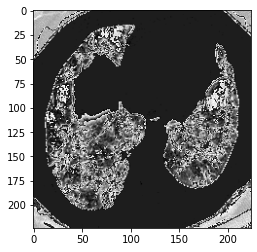

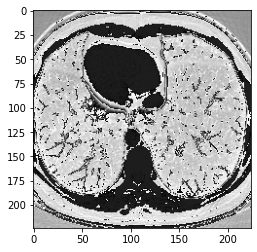

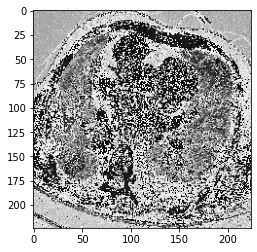

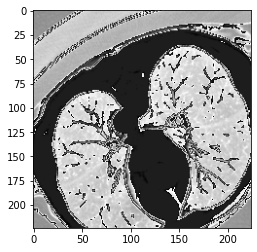

In [17]:
import matplotlib.pyplot as plt
from PIL import Image

def show_tensor_img(tensor_img):
    img=transforms.ToPILImage()(tensor_img)
    plt.figure()
    plt.imshow(img,plt.cm.gray)
    plt.show()

# Displaying some sample images from train dataset
for i in range(4):
    show_tensor_img(train_dataset[i][0])

In [18]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm=cm.numpy()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        cm=cm.astype('int')
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '{:.2f}' if normalize else '{}'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(i, j, fmt.format(cm[i, j]),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def confusion_matrix(preds, labels, conf_matrix):
    preds = torch.argmax(preds, 1)
    for p, t in zip(preds, labels):
        conf_matrix[t, p] += 1
    return conf_matrix

def calculate_all_prediction(conf_matrix):
    total_sum = conf_matrix.sum()
    correct_sum = (np.diag(conf_matrix)).sum()
    prediction = round(100*float(correct_sum)/float(total_sum),2)
    return prediction
 
def calculate_label_prediction(conf_matrix,labelidx):
    label_total_sum = conf_matrix.sum(axis=0)[labelidx]
    label_correct_sum = conf_matrix[labelidx][labelidx]
    prediction = 0
    if label_total_sum != 0:
        prediction = round(100*float(label_correct_sum)/float(label_total_sum),2)
    return prediction
 
def calculate_label_recall(conf_matrix,labelidx):
    label_total_sum = conf_matrix.sum(axis=1)[labelidx]
    label_correct_sum = conf_matrix[labelidx][labelidx]
    recall = 0
    if label_total_sum != 0:
        recall = round(100*float(label_correct_sum)/float(label_total_sum),2)
    return recall
 
def calculate_f1(prediction,recall):
    if (prediction+recall)==0:
        return 0
    return round(2*prediction*recall/(prediction+recall),2)


In [19]:
pretrained_model_path = '../input/densetnet161/densenet161_3.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = ['vgg16','vgg19','resnet101','resnet152','densenet161','densenet201'] 

# using densenet161 as our model
# can experiment with other models
model = torch.load(pretrained_model_path)
model = model.to(device)

criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam( model.parameters(), lr=0.0001,betas=(0.9, 0.999))

In [20]:
from tqdm import tqdm # for progess bar

def train(model, epoch, num_epochs, criterion,optimizer):
    model.train()
    print('-' * 100)
    #print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    running_loss = 0.0
    running_corrects = 0
    with tqdm(dataloaders['train'], unit="batch") as tepoch:
        for idx, (inputs, labels) in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs) 
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels) 

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            acc = torch.sum(preds == labels.data)/batch_size * 100.0
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            tepoch.set_postfix(loss=loss.item(), acc = acc)

    epoch_loss = running_loss / dataset_sizes['train']
    epoch_acc = running_corrects.double() / dataset_sizes['train']
    print('train_total Loss: {:.4f} Acc: {:.4f}%'.format( epoch_loss, epoch_acc*100))

In [21]:
def test(model,epoch,num_epochs,criterion,optimizer,best_acc):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    best_acc=best_acc
    best_model_wts=copy.deepcopy(model.state_dict())
    conf_matrix = torch.zeros(num_classes, num_classes) 
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloaders['val']):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            conf_matrix = confusion_matrix(outputs, labels, conf_matrix) 

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data) 

        plot_confusion_matrix(conf_matrix, classes=class_names, normalize=False, title='confusion matrix') 

    epoch_loss = running_loss / dataset_sizes['val'] 
    epoch_acc = running_corrects.double() / dataset_sizes['val'] 
    print('val_total Loss: {:.4f} Acc: {:.4f}%'.format( epoch_loss, epoch_acc*100))

    all_prediction = calculate_all_prediction(conf_matrix) 
    print('all_prediction:{}'.format(all_prediction))
    label_prediction = [] 
    label_recall = [] 
    for i in range(num_classes):
        label_prediction.append(calculate_label_prediction(conf_matrix,i))
        label_recall.append(calculate_label_recall(conf_matrix,i))

    keys=class_names
    values=list(range(num_classes))
    dictionary = dict(zip(keys, values))
    for ei,i in enumerate(dictionary):
        print(ei,'\t',i,'\t','prediction=',label_prediction[ei],'%,\trecall=',label_recall[ei],'%,\tf1=',calculate_f1(label_prediction[ei],label_recall[ei])) # 输出每个类的，精确率，召回率，F1
    p = round(np.array(label_prediction).sum()/len(label_prediction),2) 
    r = round(np.array(label_recall).sum()/len(label_prediction),2) 
    print('MACRO-averaged:\nprediction=',p,'%,recall=',r,'%,f1=',calculate_f1(p,r)) 

#     print(epoch_acc.tpye)
#     print(best_acc.type)
    if epoch_acc > best_acc:
        best_acc=epoch_acc.item()
        best_model_wts=copy.deepcopy(model.state_dict())

    return best_model_wts,best_acc,epoch_acc.item()

  0%|          | 0/1196 [00:00<?, ?batch/s]

----------------------------------------------------------------------------------------------------


Epoch 0: 100%|██████████| 1196/1196 [10:57<00:00,  1.82batch/s, acc=tensor(12.5000, device='cuda:0'), loss=0.0139]


train_total Loss: 0.1373 Acc: 95.9092%
Confusion matrix, without normalization


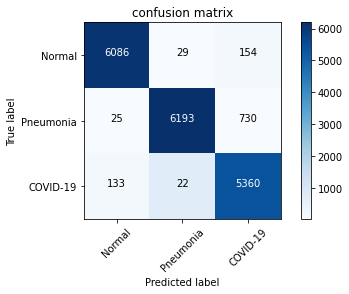

  0%|          | 0/1196 [00:00<?, ?batch/s]

val_total Loss: 0.1793 Acc: 94.1651%
all_prediction:94.17
0 	 Normal 	 prediction= 97.08 %,	recall= 97.47 %,	f1= 97.27
1 	 Pneumonia 	 prediction= 89.13 %,	recall= 99.18 %,	f1= 93.89
2 	 COVID-19 	 prediction= 97.19 %,	recall= 85.84 %,	f1= 91.16
MACRO-averaged:
prediction= 94.47 %,recall= 94.16 %,f1= 94.31
----------------------------------------------------------------------------------------------------


Epoch 1: 100%|██████████| 1196/1196 [10:29<00:00,  1.90batch/s, acc=tensor(10.9375, device='cuda:0'), loss=0.227]


train_total Loss: 0.0432 Acc: 98.6482%
Confusion matrix, without normalization


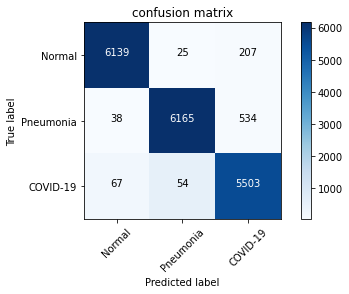

  0%|          | 0/1196 [00:00<?, ?batch/s]

val_total Loss: 0.1852 Acc: 95.0619%
all_prediction:95.06
0 	 Normal 	 prediction= 96.36 %,	recall= 98.32 %,	f1= 97.33
1 	 Pneumonia 	 prediction= 91.51 %,	recall= 98.73 %,	f1= 94.98
2 	 COVID-19 	 prediction= 97.85 %,	recall= 88.13 %,	f1= 92.74
MACRO-averaged:
prediction= 95.24 %,recall= 95.06 %,f1= 95.15
----------------------------------------------------------------------------------------------------


Epoch 2: 100%|██████████| 1196/1196 [10:19<00:00,  1.93batch/s, acc=tensor(10.9375, device='cuda:0'), loss=0.158]


train_total Loss: 0.0286 Acc: 99.1057%
Confusion matrix, without normalization


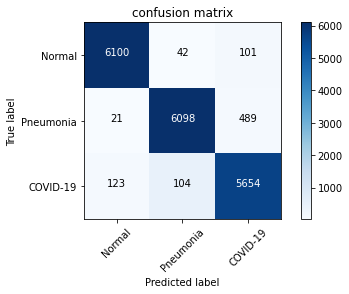

val_total Loss: 0.1855 Acc: 95.3022%
all_prediction:95.3
0 	 Normal 	 prediction= 97.71 %,	recall= 97.69 %,	f1= 97.7
1 	 Pneumonia 	 prediction= 92.28 %,	recall= 97.66 %,	f1= 94.89
2 	 COVID-19 	 prediction= 96.14 %,	recall= 90.55 %,	f1= 93.26
MACRO-averaged:
prediction= 95.38 %,recall= 95.3 %,f1= 95.34
****************************************************************************************************
best_acc:0.9530215673713431
****************************************************************************************************


In [22]:
import copy

num_epochs = 3

if __name__ == '__main__':
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    acc=[]
    for epoch in range(num_epochs):
        train(model,epoch,num_epochs,criterion,optimizer)
        best_model_wts,best_acc,epoch_acc=test(model, epoch, num_epochs, criterion, optimizer, best_acc)
        acc.append(epoch_acc)
    print('*' * 100)
    print('best_acc:{}'.format(best_acc))
    print('*' * 100)
    torch.save(best_model_wts, 'densenet201_3_model_best_acc.pth')

In [23]:
print(acc)

[0.9416506512919068, 0.9506192611573777, 0.9530215673713431]


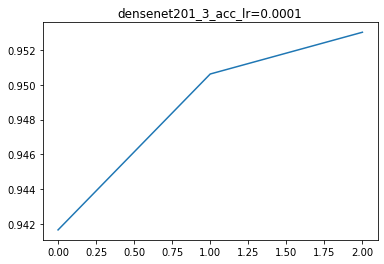

In [24]:
x=range(len(acc))
y=acc
plt.figure()
plt.title('densenet201_3_acc_lr=0.0001')
plt.plot(x,y)
plt.savefig('mini64_lr0.0001_e20_densenet201_3_acc.jpg')
plt.show()